In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# --- Standard library ---
import os
import sys
import time

# --- Scientific / data ---
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix

# --- Plotting ---
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5

# --- Local modules ---
import pcms.haar
import pcms.stats
import pcms.tree
import utils

In [4]:
DATA = os.environ['DATA']
GN_DATA = os.path.join(DATA, 'guerrero_negro/')
GG_DATA = os.path.join(DATA, 'greengenes/gg_13_8_otus')
GG_TREES = os.path.join(GG_DATA, 'trees')
GG_OTU_MAPS = os.path.join(GG_DATA, 'otus')

## Part 1: Level of Significance of Haar-like Components of Guerrero Negro Microbial Mat Dataset Against 97% Greengenes Tree

In [5]:
env_A = '1200.GN09P.o'
env_B = '1200.GN01P.o'

### Load 97% Greengenes Tree

In [6]:
tree = pcms.tree.nwk2tree(os.path.join(GG_TREES, '97_otus.nwk'), ensure_planted=True)
n_leaves = tree.find_n_leaves()
seq_id2leaf_idx = utils.build_gg_seq_id2leaf_idx_map(tree)

In [7]:
intr_nodes = tree.find_interior_nodes()
tax_filepath = os.path.join(GG_DATA, 'taxonomy/97_otu_taxonomy.txt')

In [8]:
edge_lengths = tree.get_edge_length()
min_edge_length = np.min(edge_lengths[edge_lengths != 0])
print(f"Enforced minimum edge lenght: {min_edge_length}")

for node in range(tree.n_nodes):
    tree.set_edge_length(node, max(min_edge_length, tree.get_edge_length(node)))

Enforced minimum edge lenght: 0.0001


### Load Guerrero Negro Microbial Mat Dataset

In [9]:
gn_table_filepath = os.path.join(GN_DATA, "Harris et al. (2013)/454/47908_otu_table.tsv")
gn_table_df = utils.load_seq_id_abundances_from_biom_tsv(gn_table_filepath)

In [10]:
leaf_idxs = seq_id2leaf_idx[gn_table_df['OTU ID']].values
gn_table_df.loc[:, 'Leaf Index'] = leaf_idxs
gn_table_df.sort_values('Leaf Index', inplace=True, ignore_index=True)

In [11]:
print(gn_table_df.columns)

Index(['OTU ID', '1200.GN01P', '1200.GN01P.o', '1200.GN02P', '1200.GN02P.o',
       '1200.GN03P', '1200.GN03P.o', '1200.GN04P', '1200.GN04P.o',
       '1200.GN05P', '1200.GN05P.o', '1200.GN06P', '1200.GN06P.o',
       '1200.GN07P', '1200.GN07P.o', '1200.GN08P', '1200.GN08P.o',
       '1200.GN09P', '1200.GN09P.o', 'Leaf Index'],
      dtype='object')


In [12]:
gn_counts_df = gn_table_df.loc[(gn_table_df[env_A] != 0) | (gn_table_df[env_B] != 0), [env_A, env_B]]
gn_counts_df['Leaf Index'] = gn_table_df['Leaf Index']

# convert to relative abundances
cols = gn_counts_df.columns[:-1]
gn_rel_abund_df = gn_counts_df.copy()
gn_rel_abund_df[cols] = gn_counts_df[cols].div(gn_counts_df[cols].sum(axis=0), axis=1)

In [13]:
gn_counts_df

,1200.GN09P.o,1200.GN01P.o,Leaf Index
9,5,0,2520
10,6,0,2526
17,0,1,2549
20,0,1,2593
31,1,0,2662
...,...,...,...
1684,0,1,80733
1686,1,0,82314
1688,2,0,82499
1692,2,0,82516


In [14]:
gn_rel_abund_df

,1200.GN09P.o,1200.GN01P.o,Leaf Index
9,0.004941,0.000000,2520
10,0.005929,0.000000,2526
17,0.000000,0.000551,2549
20,0.000000,0.000551,2593
31,0.000988,0.000000,2662
...,...,...,...
1684,0.000000,0.000551,80733
1686,0.000988,0.000000,82314
1688,0.001976,0.000000,82499
1692,0.001976,0.000000,82516


### Compute Haar-like Coordinates and Haar-components

In [15]:
Q, S = pcms.haar.sparsify(tree)

In [16]:
a_s = gn_rel_abund_df[env_A]
b_s = gn_rel_abund_df[env_B]

indices = gn_rel_abund_df['Leaf Index'].values
n_leaves = tree.find_n_leaves()

a_vals = a_s.values
a = np.zeros((n_leaves,))
a[indices] = a_vals

b_vals = b_s.values
b = np.zeros((n_leaves,))
b[indices] = b_vals

diff = a - b

In [17]:
haar_coords = Q.T @ diff
haar_comps  = haar_coords**2 * S.diagonal()

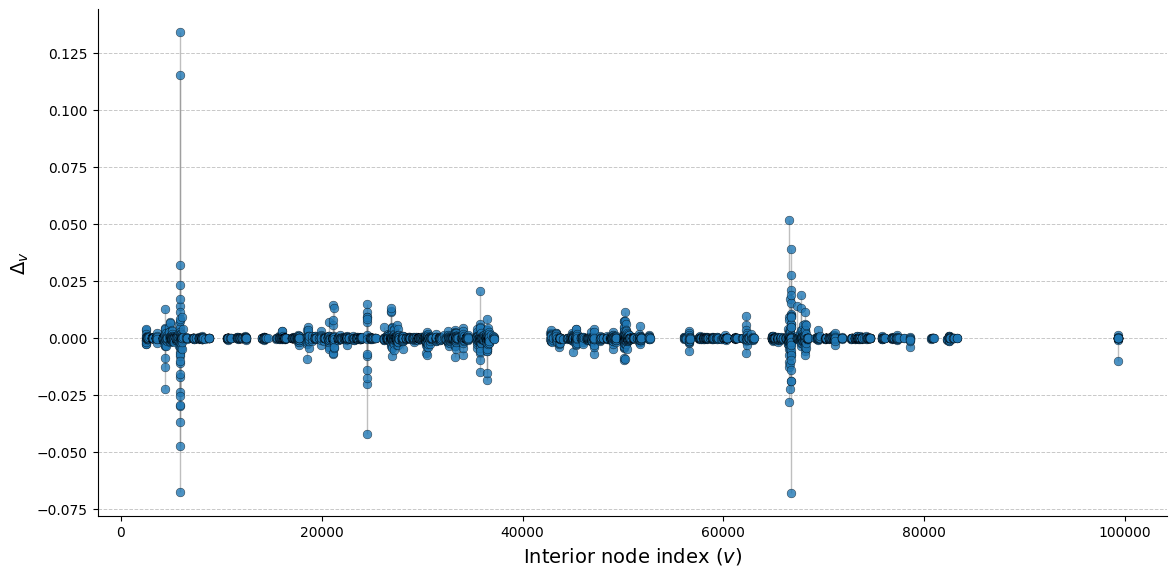

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

idx = np.where(haar_coords)[0]
y = haar_coords[idx]
x = idx

utils.plot.haar_scatter(ax, x, y)

ax.set_xlabel('Interior node index ($v$)', fontsize=14)
ax.set_ylabel(r'$\Delta_v$', fontsize=14)

plt.tight_layout()
plt.show()

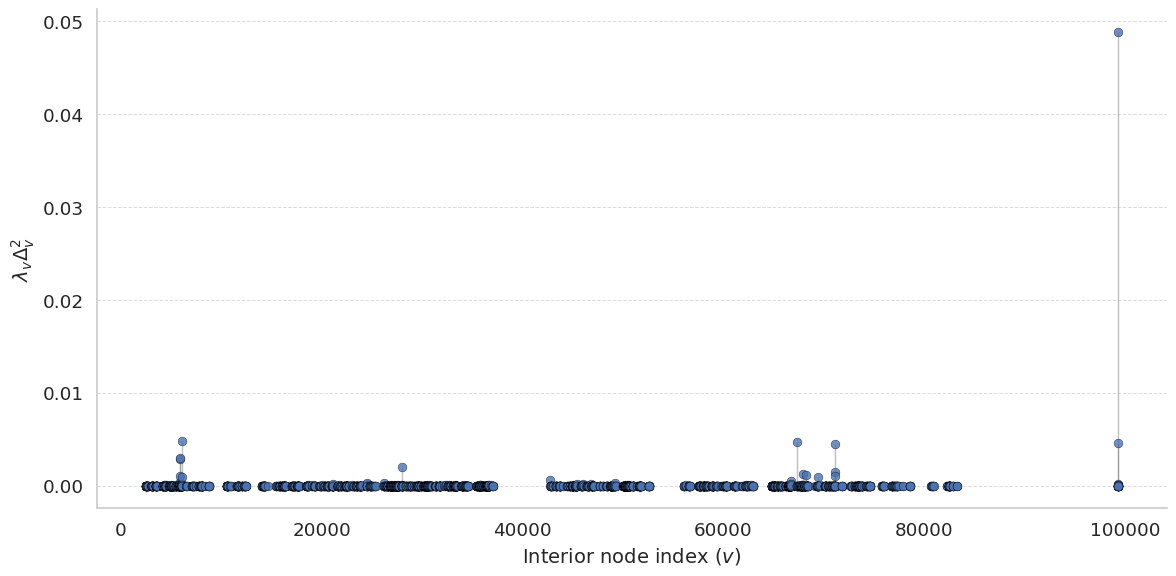

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))

idx = np.where(haar_comps)[0]
y = haar_comps[idx]
x = idx

utils.plot.haar_scatter(ax, x, y)

ax.set_xlabel('Interior node index ($v$)', fontsize=14)
ax.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)

plt.tight_layout()
plt.show()

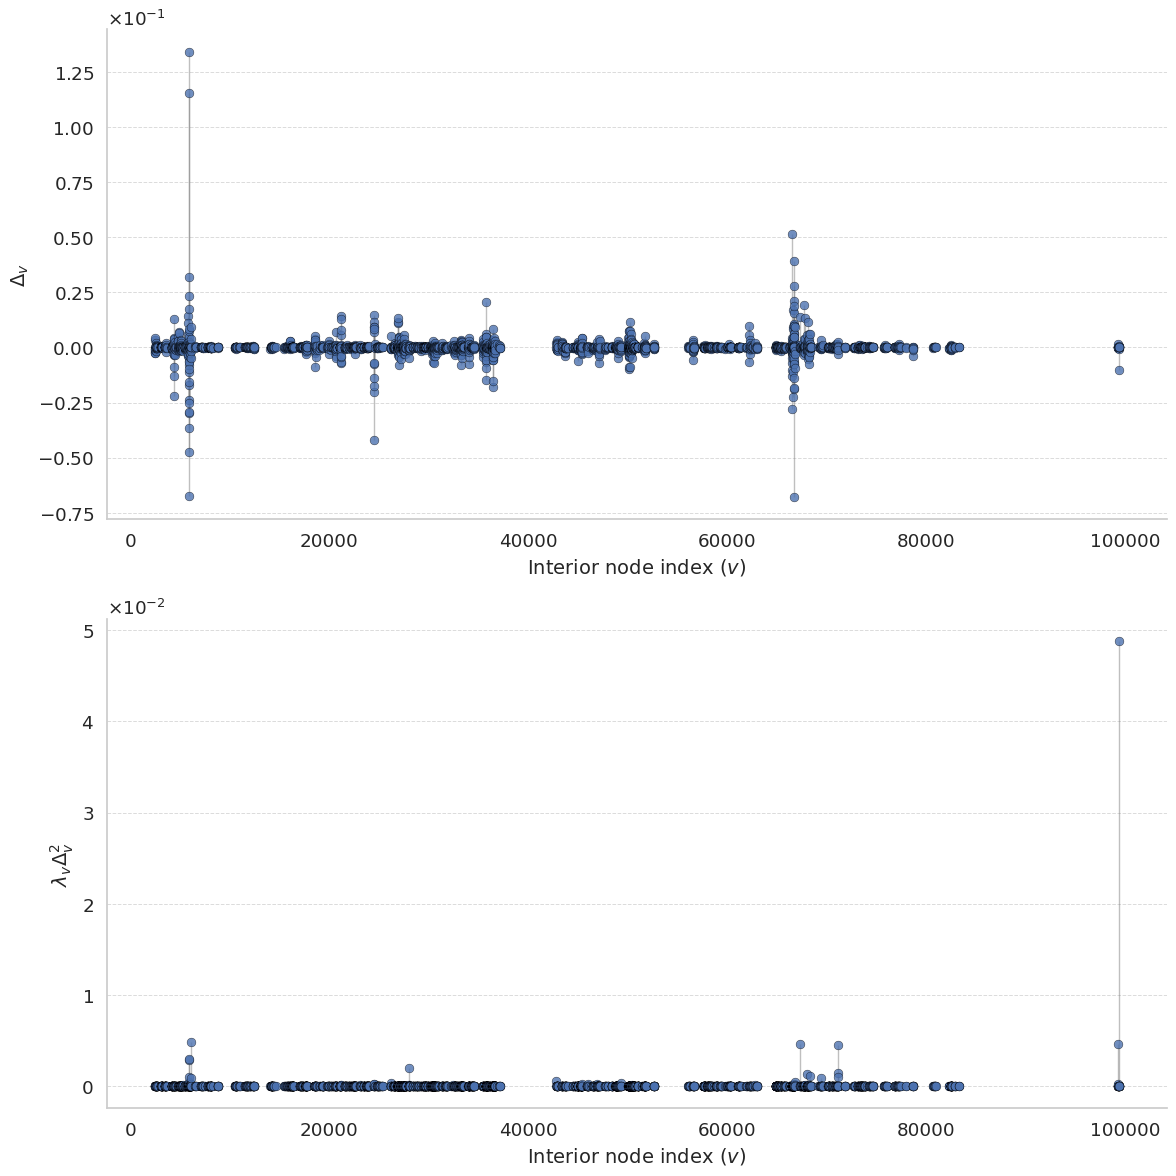

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharey=False)

# --- Plot 1: haar_coords plot ---
x1 = np.where(haar_coords)[0]
y1 = haar_coords[x1]

utils.plot.haar_scatter(ax1, x1, y1)

ax1.set_xlabel('Interior node index ($v$)', fontsize=14)
ax1.set_ylabel(r'$\Delta_v$', fontsize=14)

ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# --- Plot 2: haar_comps plot ---
x2 = np.where(haar_comps)[0]
y2 = haar_comps[x2]

utils.plot.haar_scatter(ax2, x2, y2)

ax2.set_xlabel('Interior node index ($v$)', fontsize=14)
ax2.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)

ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.tight_layout()
plt.show()

### Permutation Test for Statistical Significance of Haar-components

#### How well do the significant components describe the data?

In [21]:
intr_nodes = tree.find_interior_nodes()
subtree_starts = tree.find_subtree_start_indices()
subtree_sizes = tree.get_subtree_size()

In [22]:
counts_ = gn_counts_df.iloc[:, :-1]
counts_ = np.asarray(counts_)
leaves = gn_counts_df['Leaf Index']
counts = np.zeros((tree.find_n_leaves(), 2))
counts[leaves, 0] = counts_[:, 0]
counts[leaves, 1] = counts_[:, 1]
counts = counts.astype(int)

In [23]:
mask = np.where(haar_coords != 0)[0]
node_idxs = intr_nodes[mask]
ys = np.abs(haar_coords[mask])

In [24]:
cdf_vals = pcms.stats.cdf_haar_coordinate_perm(
    ys,
    tree,
    node_idxs,
    counts,
    eps = 0.005,
    delta = 0.001
)
pvals = 1 - cdf_vals

In [25]:
node2nz_idx = {nzidx : idx for idx, nzidx in enumerate(np.where(haar_coords != 0)[0])}
nz2node_idx = {idx : nzidx for idx, nzidx in enumerate(np.where(haar_coords != 0)[0])}

In [26]:
alpha = 0.05
do_reject = pvals < alpha
do_reject_ = np.zeros(haar_coords.shape, dtype=bool)
mask = np.where(haar_coords != 0)[0]
do_reject_[mask] = do_reject

In [27]:
sort_idx = np.argsort(haar_comps)[::-1]
is_pos = (haar_comps[sort_idx] > 0.0)
sort_idx_pos = sort_idx[is_pos]
last = np.where(do_reject_[sort_idx_pos])[0][-1]
print(f"Last significant Haar-component occurs at rank: {last}")
print(f"Total statistically significant Haar-components: {np.count_nonzero(do_reject)}")

Last significant Haar-component occurs at rank: 4227
Total statistically significant Haar-components: 957


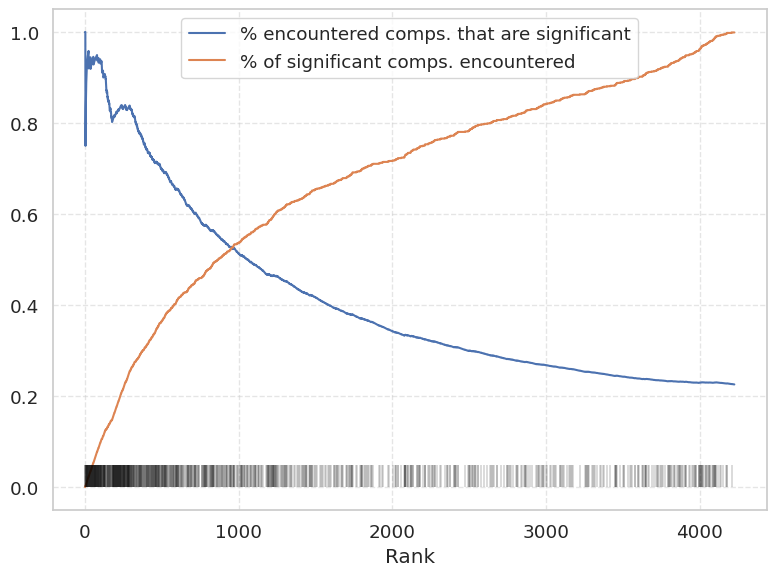

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
tot_sig = np.count_nonzero(do_reject_)
f = lambda x: np.count_nonzero(do_reject_[sort_idx_pos][:x]) / x
g = lambda x: np.count_nonzero(do_reject_[sort_idx_pos][:x]) / tot_sig
xs = np.arange(1, last)
ys = np.array([f(x) for x in xs])
yys = np.array([g(x) for x in xs])
ax.plot(xs, ys, label='% encountered comps. that are significant')
ax.plot(xs, yys, label='% of significant comps. encountered')
ax.vlines(x=xs[do_reject_[sort_idx_pos[:last-1]]], ymin=0, ymax=0.05, colors='black', lw=0.2)
# ax.set_xscale('symlog', linthresh=10)
ax.set_xlabel('Rank')
ax.grid(True, which='both', linestyle='--', alpha=0.5)
ax.legend(loc='upper center')
plt.tight_layout()
plt.show()

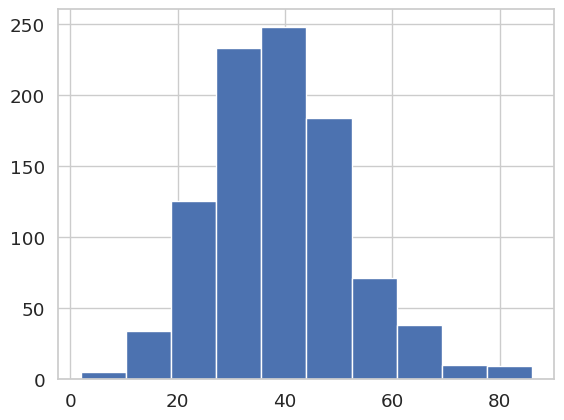

In [29]:
sig_nodes = np.where(do_reject_)[0]
sig_depths = np.array([tree.find_ancestors(n).size-1 for n in intr_nodes[sig_nodes]])
plt.hist(sig_depths)
plt.show()

In [30]:
haar_coords_reject_null = np.zeros(haar_coords.shape)
haar_coords_reject_null[do_reject_] = haar_coords[do_reject_]

y1 = diff
thresh = np.min(np.abs(y1)[y1 != 0])
y2 = Q @ haar_coords_reject_null
y2[y1 == 0] = 0.0
x = np.arange(len(y1))

In [31]:
a, b = np.count_nonzero(haar_coords_reject_null), np.count_nonzero(haar_coords)
print(f"Number of Haar-like components found to be statistically significant: {a} of {b}")

Number of Haar-like components found to be statistically significant: 957 of 4271


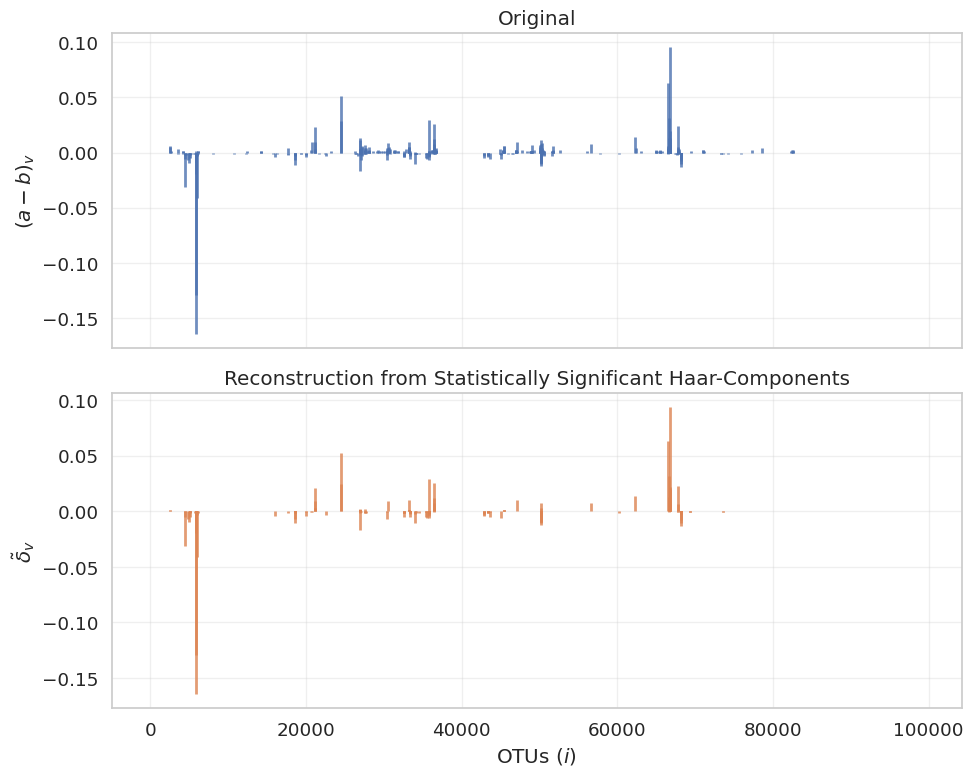

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.vlines(x, 0, y1, colors="C0", alpha=0.8, linewidth=2)
ax1.set_ylabel("$(a - b)_v$")
ax1.set_title("Original")
ax1.grid(True, alpha=0.3)

ax2.vlines(x, 0, y2, colors="C1", alpha=0.8, linewidth=2)
ax2.set_xlabel("OTUs ($i$)")
ax2.set_ylabel(r"$\tilde{\delta}_v$")
ax2.set_title("Reconstruction from Statistically Significant Haar-Components")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### What is the significance the dominant Haar-components?

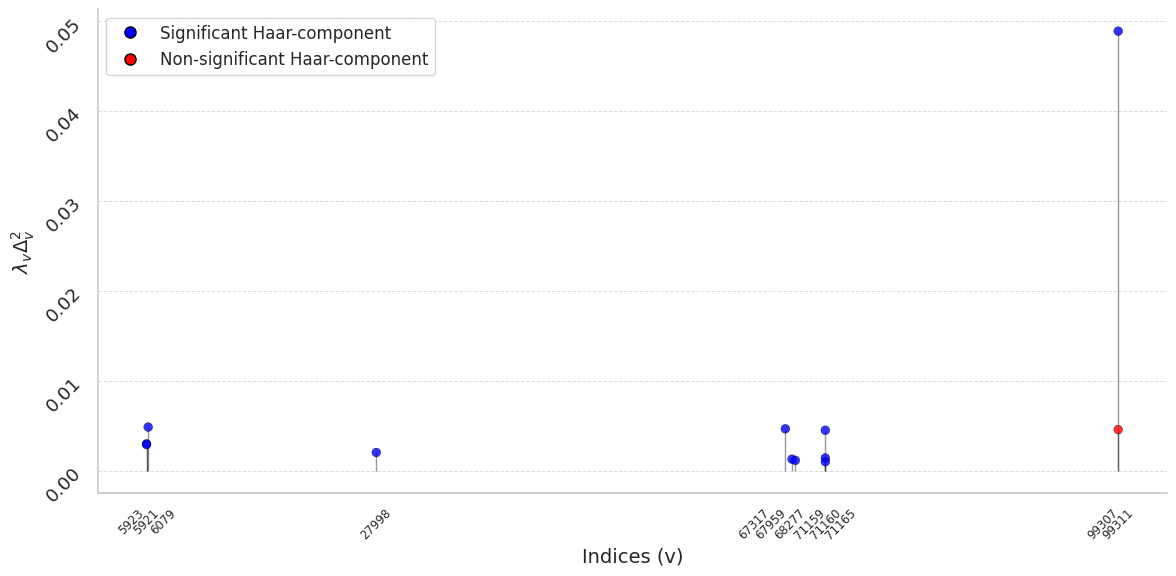

In [33]:
sns.set(style="whitegrid", font_scale=1.2)

fig, ax = plt.subplots(figsize=(12, 6))

num_points = 12
sort_idx = np.argsort(haar_comps)[::-1][:num_points]
color_idx = np.argsort(haar_comps[haar_comps > 0.0])[::-1][:num_points]
colors = np.where(do_reject[color_idx], 'blue', 'red')
y = haar_comps[sort_idx]
x = sort_idx

for xi, yi, ci in zip(x, y, colors):
    ax.vlines(xi, 0, yi, color='black', alpha=0.4, linewidth=1.0, zorder=2)

scatter = ax.scatter(
    x, y,
    c=colors,
    s=40,
    alpha=0.8,
    edgecolors='black',
    linewidth=0.3,
    zorder=3
)

legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=r'Significant Haar-component', markerfacecolor='blue',
           markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w',
           label=r'Non-significant Haar-component', markerfacecolor='red',
           markeredgecolor='black', markersize=8)
]
ax.legend(handles=legend_elements, frameon=True, fontsize=12)

ax.set_xlabel('Indices (v)', fontsize=14)
ax.set_ylabel(r'$\lambda_v \Delta_v^2$', fontsize=14)
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)
ax.set_xticks(x + [0, 1400, -3000, -1500, 0, -1500, 0, 0, -1500, -2000, -500, 1500], labels=x+1, fontsize=8.5)
ax.tick_params(rotation=45)
sns.despine()

plt.tight_layout()
plt.show()

In [34]:
N = 12

print(f"{'Index':>10} {'Depth':>10} {'Subtree Size':>14} {'Split Size':>14} {'Component':>14} {'P-Value':>14}")
print("-" * 80)

sort_idx = np.argsort(haar_comps)[::-1]

eps = 0.005
delta = 0.001
n_samples = np.ceil(1.0 / (2 * eps**2) * np.log(2 / delta))

for rank in range(N):
    idx = sort_idx[rank]
    node_idx = intr_nodes[idx]

    pval = pvals[node2nz_idx[idx]]
    pval = pval if pval > 0 else 1 / (n_samples + 1)

    children = tree.find_children(node_idx)
    split = np.min([tree.get_subtree_size(c) for c in children])

    depth = tree.find_ancestors(node_idx).size

    print(
        f"{idx+1:>10d} "
        f"{depth-1:>10d} "
        f"{subtree_sizes[node_idx]:>14d} "
        f"{split:>14d}"
        f"{haar_comps[idx]:>14.4f} "
        f"{pval:>14.3e}"
    )

     Index      Depth   Subtree Size     Split Size      Component        P-Value
--------------------------------------------------------------------------------
     99311         10          95297           2118        0.0488      6.578e-06
      6079         18           1792            769        0.0048      6.578e-06
     67317         34            835            270        0.0047      6.578e-06
     99307         14          50035          21893        0.0046      5.641e-02
     71160         20          14472           4899        0.0045      6.578e-06
      5923         25            600            272        0.0030      6.578e-06
      5921         27            240             87        0.0029      6.578e-06
     27998         15          20765           7640        0.0020      3.085e-03
     71159         21           4899           1513        0.0014      6.578e-06
     67959         32           1477            641        0.0013      6.578e-06
     68277         27      

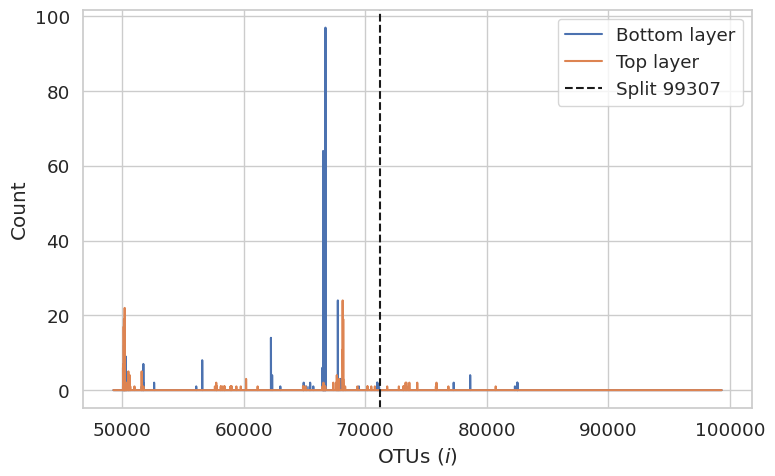

In [35]:
fig, ax = plt.subplots(figsize=(8, 5))

node_idx = intr_nodes[99306]

x = np.arange(subtree_starts[node_idx], subtree_starts[node_idx] + subtree_sizes[node_idx])
y = counts[x, :]
cutoff = subtree_sizes[tree.get_child(node_idx)]

ax.plot(x, y[:,0], label="Bottom layer")
ax.plot(x, y[:,1], label="Top layer")
ax.axvline(x[0] + cutoff, linestyle='--', color='k', label='Split 99307')

ax.set_xlabel("OTUs ($i$)")
ax.set_ylabel("Count")

ax.legend()

plt.tight_layout()
plt.show()

### Taxonomic Classification of Splits of Dominant Haar-component

In [36]:
def tax_of_split(tree, idx, abunds):
    intr_nodes = tree.find_interior_nodes()
    tax_map_left  = utils.build_gg_otu_id2tax_map(tree, tax_filepath, 
                                                  node=tree.get_child(intr_nodes[idx]), 
                                                  a_abunds=abunds)
    tax_map_right = utils.build_gg_otu_id2tax_map(tree, tax_filepath, 
                                                  node=tree.get_sibling(tree.get_child(intr_nodes[idx])), 
                                                  a_abunds=abunds)
    return tax_map_left, tax_map_right


def truncate_lcr(lcr: str, max_ranks: int = 3) -> str:
    ranks = lcr.split(';')
    if len(ranks) > max_ranks:
        return ''.join(ranks[-max_ranks:])
    else:
        return lcr


def format_tax_table(tree, idxs, abunds, max_ranks=1):
    results = []

    for idx in idxs:
        left, right = tax_of_split(tree, idx, abunds)
        results.append({
            "node": idx,
            "left": {
                "lcr": truncate_lcr(left['lcr'], max_ranks),
                "abundances": [
                    {"taxon": tax.strip(),
                     "ref_frac": float(f"{row.otu_fracs:.2f}"),
                     "abund_frac": float(f"{row.abund_fracs:+.3f}")}
                    for tax, row in left['fracs'].iterrows()
                    if round(row.otu_fracs, 2) > 0.0
                ]
            },
            "right": {
                "lcr": truncate_lcr(right['lcr'], max_ranks),
                "abundances": [
                    {"taxon": tax.strip(),
                     "ref_frac": float(f"{row.otu_fracs:.2f}"),
                     "abund_frac": float(f"{row.abund_fracs:+.3f}")}
                    for tax, row in right['fracs'].iterrows()
                    if round(row.otu_fracs, 2) > 0.0
                ]
            }
        })

    return results

In [37]:
N = 12
gn_results = format_tax_table(tree, sort_idx[:N], abunds=diff)

In [38]:
def plot_split(ax, split_data, min_frac=1e-3, full_height=0.6):
    # Load data
    left_df = pd.DataFrame(split_data["left"]["abundances"])
    right_df = pd.DataFrame(split_data["right"]["abundances"])

    # Strip whitespace
    left_df["taxon"] = left_df["taxon"].str.strip()
    right_df["taxon"] = right_df["taxon"].str.strip()

    # Filter out small abundances
    left_df = left_df[np.abs(left_df["abund_frac"]) >= min_frac].copy()
    right_df = right_df[np.abs(right_df["abund_frac"]) >= min_frac].copy()

    # Max absolute value for x-scale
    max_abs = max(left_df["abund_frac"].abs().max() if not left_df.empty else 0,
                  right_df["abund_frac"].abs().max() if not right_df.empty else 0)

    pick_color = lambda x: "#2166ac" if x > 0 else "#b30c20"

    # Sort each subtree independently
    left_df_sorted = left_df.sort_values("abund_frac")
    right_df_sorted = right_df.sort_values("abund_frac")

    # Assign y positions separately
    left_y = np.arange(len(left_df_sorted))
    right_y = np.arange(len(right_df_sorted))

    # Plot left bars
    for i, row in enumerate(left_df_sorted.itertuples()):
        ax.barh(
            left_y[i],
            row.abund_frac,
            color=pick_color(row.abund_frac),
            edgecolor="black",
            height=full_height
        )
    
    # Divider line for left tree
    y0 = len(left_df_sorted) - 0.5
    if not left_df_sorted.empty:
        ax.axhline(y0, color='gray', linestyle='--', linewidth=2)

    # Plot right bars
    for i, row in enumerate(right_df_sorted.itertuples()):
        ax.barh(
            right_y[i] + len(left_y),  # offset so right bars are below left bars
            row.abund_frac,
            color=pick_color(row.abund_frac),
            edgecolor="black",
            height=full_height
        )

    # Center line at 0
    ax.axvline(0, color="black", linewidth=0.8)

    # Y-axis labels (concatenate left + right taxa)
    ax.set_yticks(np.arange(len(left_y) + len(right_y)))
    ax.set_yticklabels(list(left_df_sorted["taxon"]) + list(right_df_sorted["taxon"]))

    ax.set_xlim(-max_abs - 0.1, max_abs + 0.1)

In [39]:
def rename_unclassified(results):
    for node in results:
        for side in ["left", "right"]:
            for abund in node[side]["abundances"]:
                tax = abund["taxon"].strip()
                if tax.endswith("__"):
                    prefix = tax[:3]  # e.g., "c__" or "p__"
                    abund["taxon"] = f"{prefix}Unclassified"

In [40]:
rename_unclassified(gn_results)

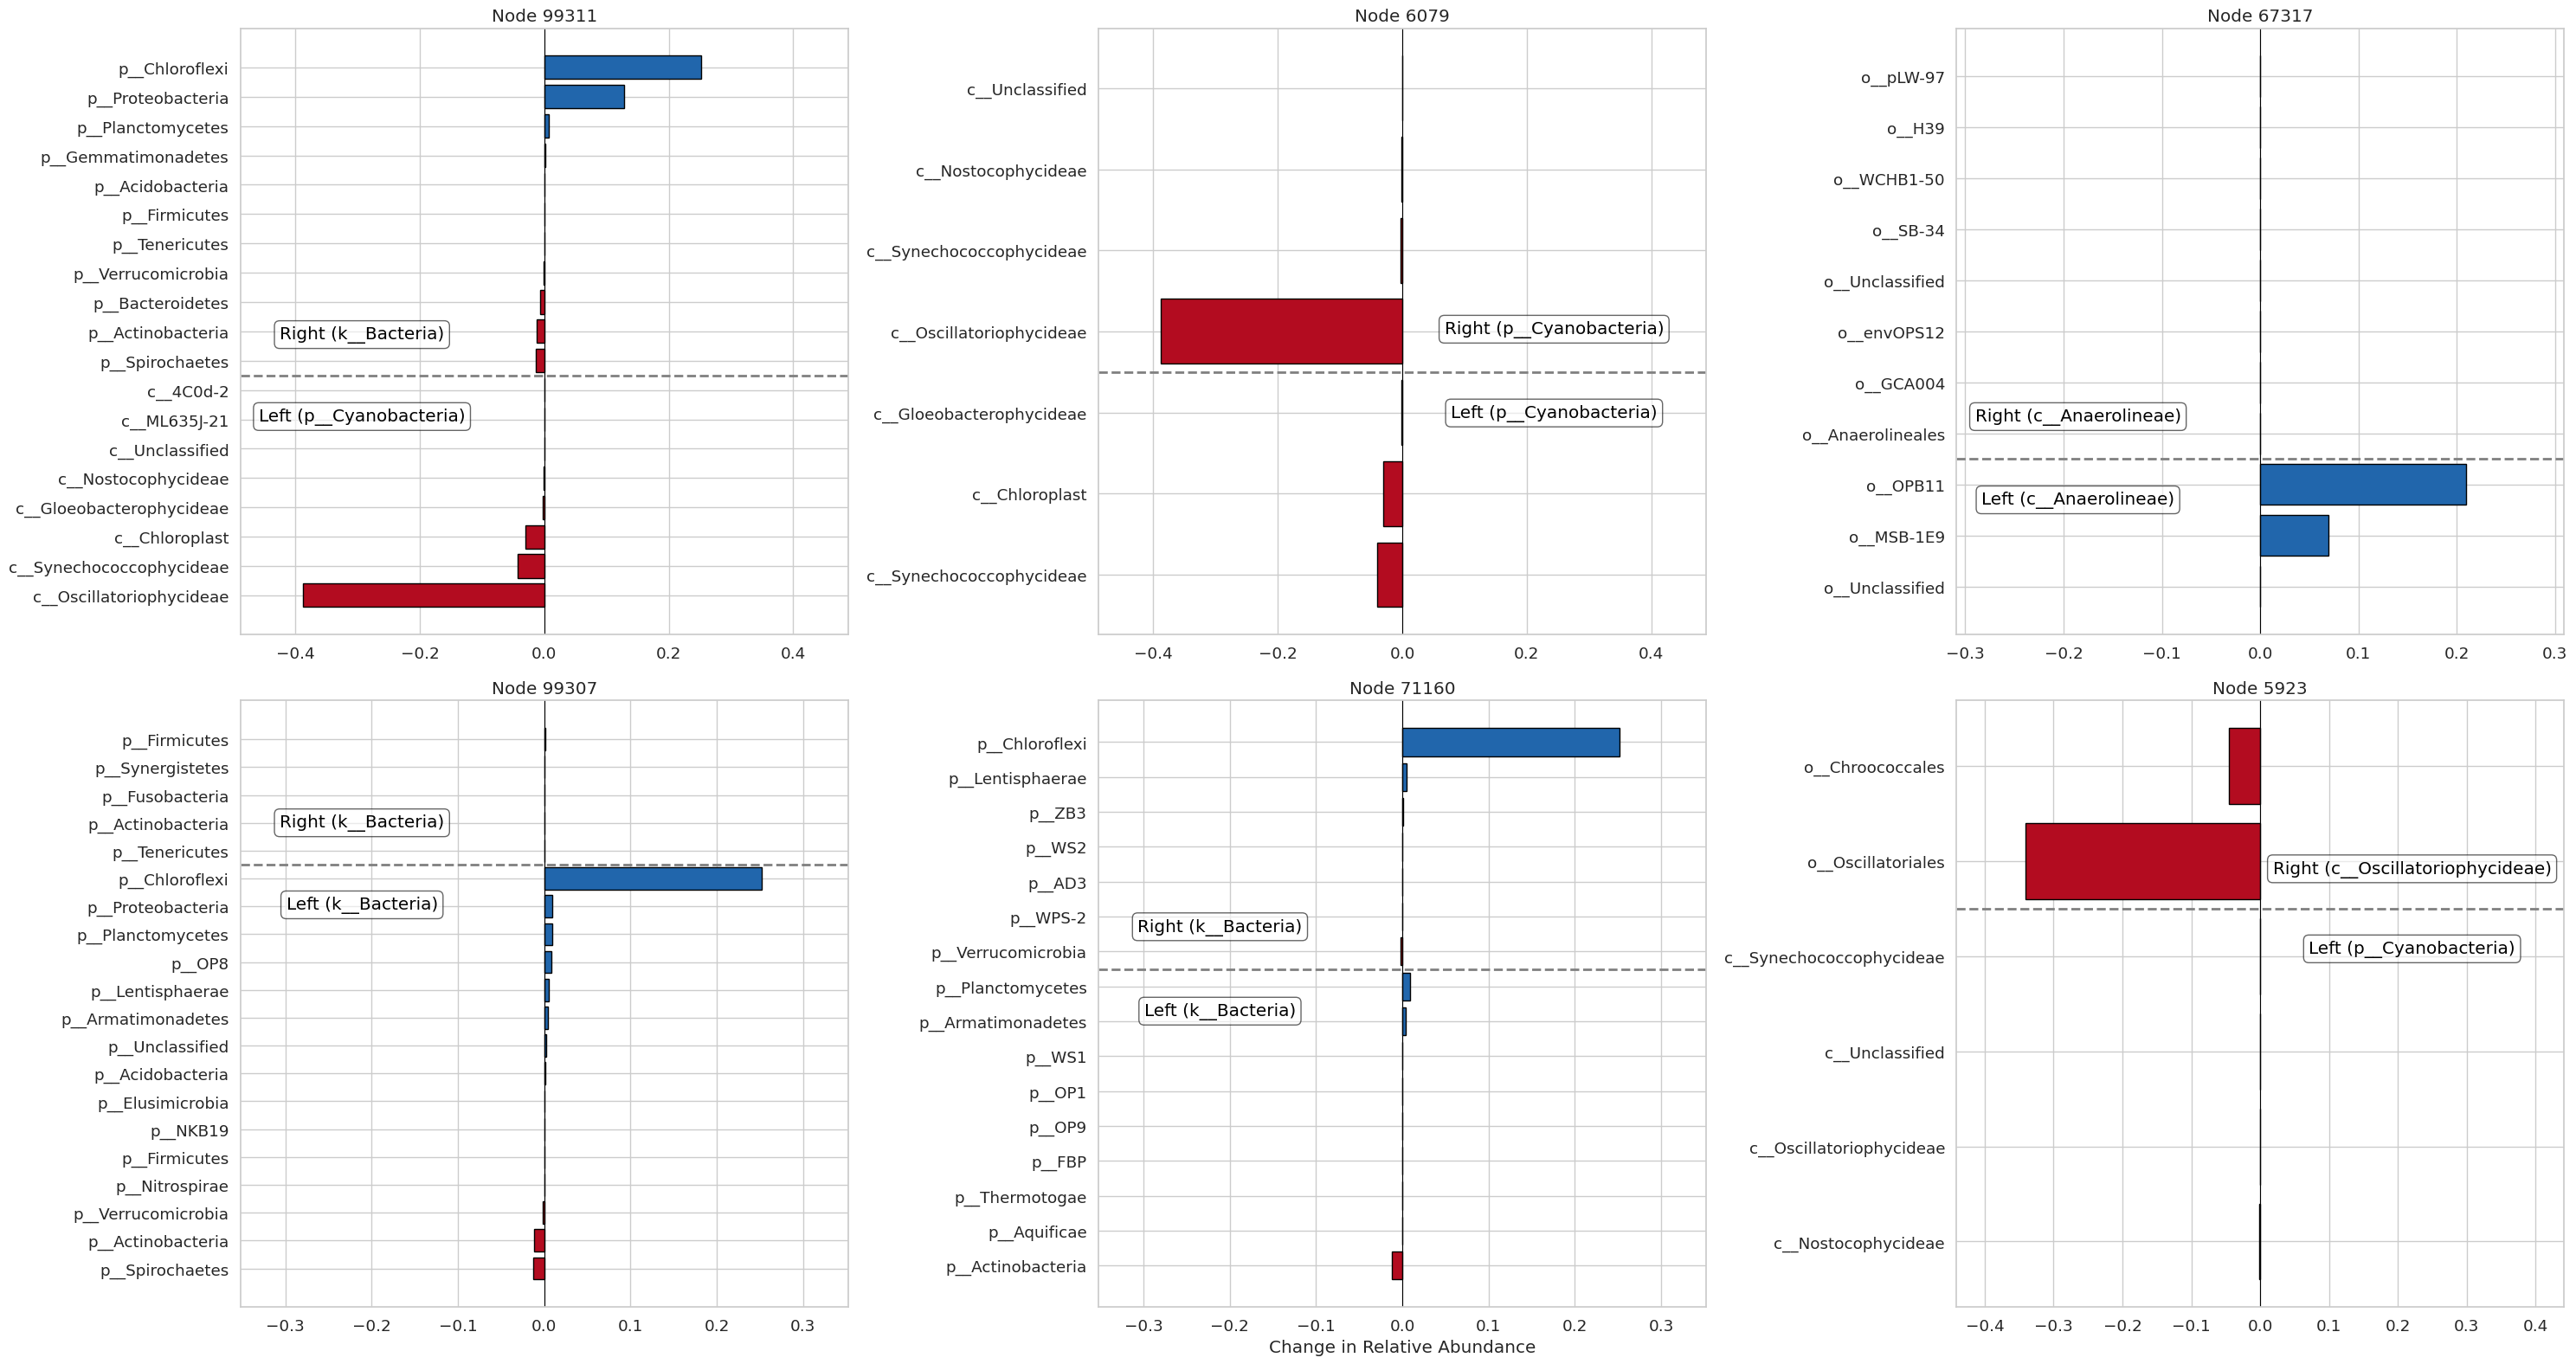

In [50]:
# Determine bar heights
full_height =  0.8
overlap_height = full_height * 2/3

# Plot
fig, axes = plt.subplots(2, 3, figsize=(30, 16))
axes = axes.flatten()

yshift1 = np.array([0.425, 0.415, 0.27, 0.75, 0.565, 0.655]) + 0.05
yshift0 = np.array([0.35, 0.33, 0.19, 0.675, 0.485, 0.575]) - 0.05
xshift  = [0.2, 0.75, 0.2, 0.2, 0.2, 0.75]

for i, ax in enumerate(axes[:6]):
    split_data = gn_results[i]

    # split plot
    plot_split(
        ax, split_data, min_frac=0.0, full_height=full_height
    )
    ax.set_title(f"Node {split_data['node']+1}")

    # text box
    y0 = yshift0[i] * ax.get_ylim()[1]
    y1 = yshift1[i] * ax.get_ylim()[1]
    x0 = ((1 - xshift[i]) * ax.get_xlim()[0] + xshift[i] * ax.get_xlim()[1])
    bbox_props = dict(boxstyle="round,pad=0.3", facecolor="white",
                      edgecolor="black", alpha=0.6)
    ax.text(x0, y0, f"Left ({split_data['left']['lcr'].strip()})", 
            ha='center', va='bottom', color='black', bbox=bbox_props)
    ax.text(x0, y1, f"Right ({split_data['right']['lcr'].strip()})", 
            ha='center', va='top', color='black', bbox=bbox_props)

# X-axis labels for bottom row
axes[-2].set_xlabel('Change in Relative Abundance')

plt.tight_layout()
plt.show()

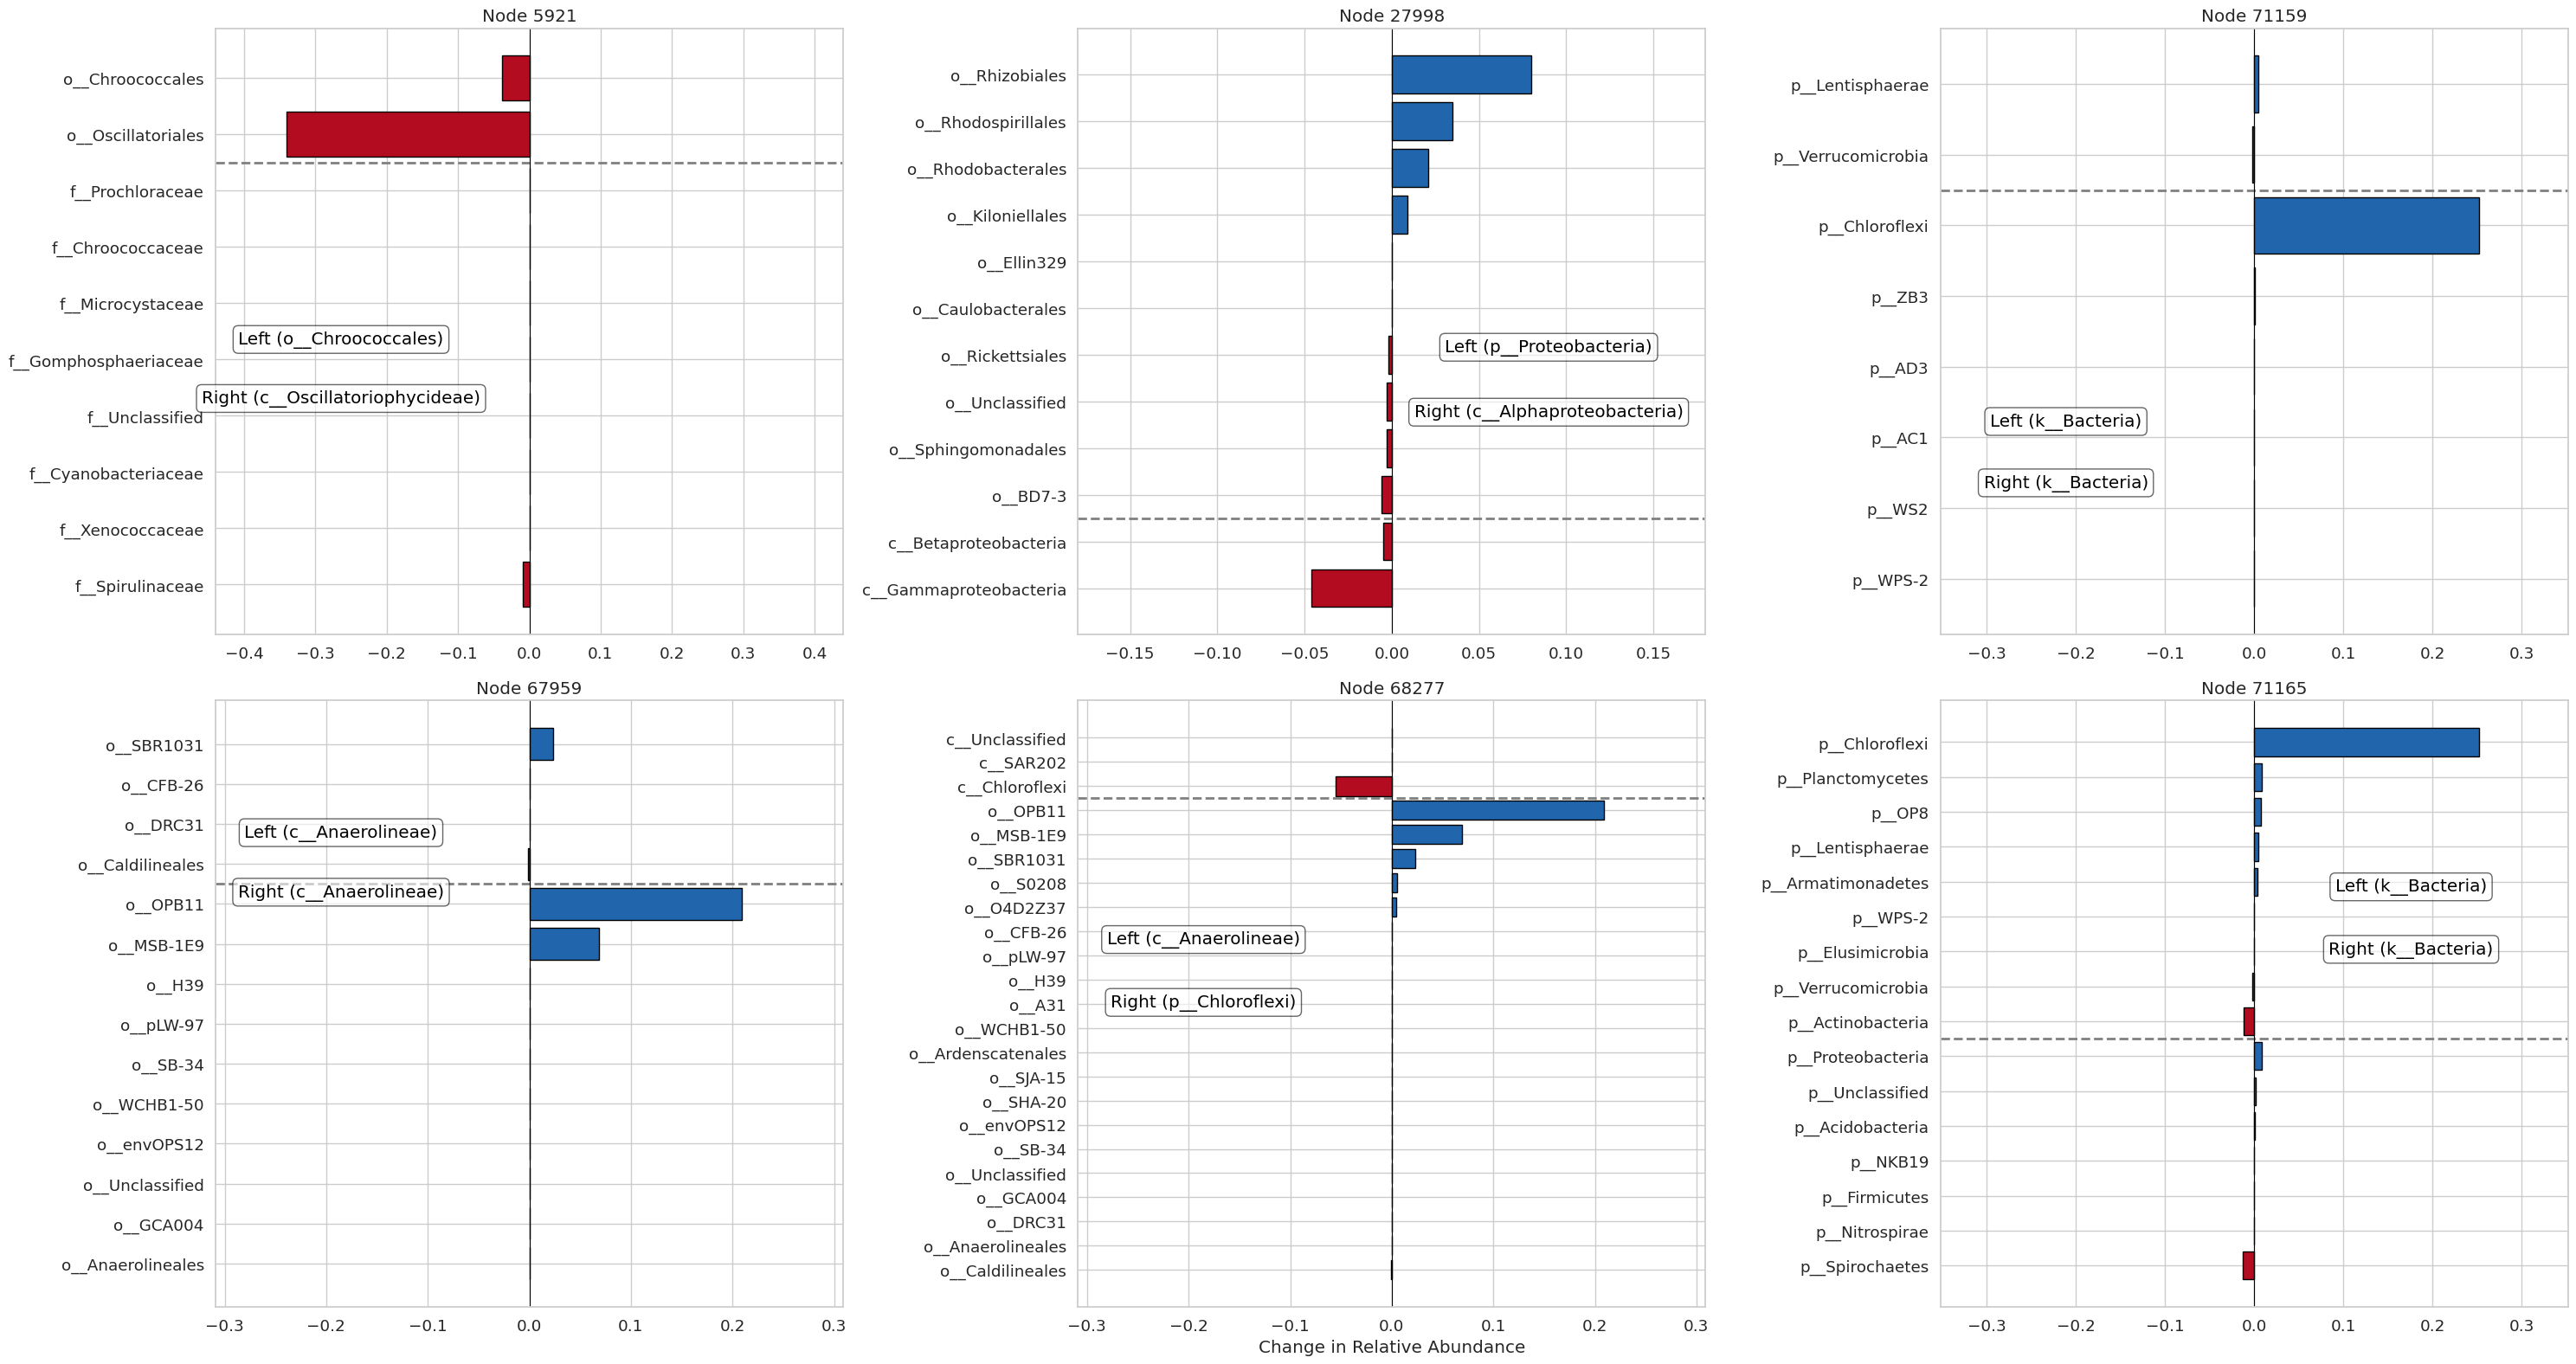

In [42]:
# Determine bar heights
full_height =  0.8
overlap_height = full_height * 2/3

# Plot
fig, axes = plt.subplots(2, 3, figsize=(30, 16))
axes = axes.flatten()

yshift0 = [0.425, 0.415, 0.27, 0.75, 0.565, 0.655]
yshift1 = [0.35, 0.33, 0.19, 0.675, 0.485, 0.575]
xshift  = [0.2, 0.75, 0.2, 0.2, 0.2, 0.75]

for i, ax in enumerate(axes[:6]):
    split_data = gn_results[i+6]

    # split plot
    plot_split(
        ax, split_data, min_frac=0.0, full_height=full_height
    )
    ax.set_title(f"Node {split_data['node']+1}")

    # text box
    y0 = yshift0[i] * ax.get_ylim()[1]
    y1 = yshift1[i] * ax.get_ylim()[1]
    x0 = ((1 - xshift[i]) * ax.get_xlim()[0] + xshift[i] * ax.get_xlim()[1])
    bbox_props = dict(boxstyle="round,pad=0.3", facecolor="white",
                      edgecolor="black", alpha=0.6)
    ax.text(x0, y0, f"Left ({split_data['left']['lcr'].strip()})", 
            ha='center', va='bottom', color='black', bbox=bbox_props)
    ax.text(x0, y1, f"Right ({split_data['right']['lcr'].strip()})", 
            ha='center', va='top', color='black', bbox=bbox_props)

# X-axis labels for bottom row
axes[-2].set_xlabel('Change in Relative Abundance')

plt.tight_layout()
plt.show()